In [1]:
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import pandas as pd
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

import glob

from util_train_test import load_model, test
from util_model import load_demo

from dataloader import image_loader
from sklearn import linear_model

## Load Model

In [38]:
model_type = 'SAE'
load_model_name = 'Autoencoder'
zoomlevel = 'zoom13'
output_dim = 1
model_run_date = '2111111'
ys = [0,1,2,5,9,10,12]
y = 0
variable_names = ['trp_gen','auto_share','tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute','avg_tt_to_work','inc_per_capita']
model_save_variable_names = ['trpgen','autoshare','totpop','pct25-34','pct35-50','pctsenior',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pctcolgrad','pctpt','avg_tt_to_work','inc']

In [3]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':len(variable_names)-1,
       'cardinality':1,
       'epochs':20,
       'batch_size':16,
       'base_lr':0.1,
       'weight_decay':0.0005,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[150,225]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':False}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [4]:
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], run_config['num_workers'], 
                                         data_config['image_size'], recalculate_normalize=False)

In [39]:
model_path = glob.glob(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                       model_save_variable_names[y]+"_"+model_run_date+"_*.pt")
# model_path = [model_dir+"zoom13_2048_199.pt"]
if len(model_path) == 1:
    saved = torch.load(model_path[0], map_location=torch.device("cuda:2"))
    print(model_path[0],"loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_dir+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                       model_save_variable_names[y]+"_"+model_run_date+"_*.pt")
    print(model_path)

/dream/qingyi/image_chicago/models/SAE_zoom13_2048_trpgen_2111111_60.pt loaded.


In [40]:
# load model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder',load_model_name, config)
model.load_state_dict(saved['model_state_dict']);

Encoder torch.Size([1, 2048, 1, 1])
Decoder: torch.Size([1, 3, 224, 224])


## Encoder Embeddings

In [41]:
ct = []
encoder_output = []

for step, data in enumerate(train_loader):
    ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
    encoder_output += [encoder(data[1]).detach().numpy()]

for step, data in enumerate(test_loader):
    ct += [s[s.rindex("/")+1: s.rindex("_")]for s in data[0]]
    encoder_output += [encoder(data[1]).detach().numpy()]

encoder_output = np.vstack(encoder_output)

In [42]:
print(encoder_output.shape)
encoder_output = encoder_output.reshape(len(encoder_output), -1)

(9250, 2048, 1, 1)


## Aggregate Embeddings for Regression

In [43]:
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))


from torchvision import transforms
for i in range(50):#len(aggregate_embeddings)):
    decoder_in = torch.tensor(aggregate_embeddings[i])
    decoder_in = decoder_in.view(1, -1, model_config['output_dim'], model_config['output_dim'])
    reconstruct = decoder(decoder_in)[0]
    im = transforms.ToPILImage()(reconstruct).convert("RGB")
    im.save(out_dir+zoomlevel+"/"+str(model_config['output_dim']**2*2048)+"_"+unique_ct[i]+"_reg.png")
    

In [22]:
np.array(aggregate_embeddings).shape

(925, 2048)

## Load Trip Behavior

In [23]:
demo_cs, demo_np = load_demo(data_dir)
demo_index = [demo_cs.index(i) for i in unique_ct]
demo_np = demo_np[demo_index]


In [44]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x_train, x_test, demo_train, demo_test = train_test_split(aggregate_embeddings, demo_np, test_size = 0.2, random_state=5)
y_train = demo_train[:,y]
y_test = demo_test[:,y]

demo_loo_train = demo_train[:, np.delete(np.arange(len(variable_names)), y, 0)]
demo_loo_test = demo_test[:, np.delete(np.arange(len(variable_names)), y, 0)]

In [45]:
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
with open(out_dir+"regression_results.csv", "a") as f:
        f.write("%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d,%s\n" % (model_type, variable_names[y], -1, 
            lr.score(x_train, y_train), lr.score(x_test, y_test), 'lr', zoomlevel,
            np.sum(lr.coef_ != 0), len(lr.coef_), model_run_date))

In [46]:
for a in np.linspace(1,4,10):
    lasso = linear_model.Lasso(alpha = a)
    lasso.fit(x_train, y_train)
    with open(out_dir+"regression_results.csv", "a") as f:
        f.write("%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d,%s\n" % (model_type, variable_names[y], a, 
            lasso.score(x_train, y_train), lasso.score(x_test, y_test), 'lasso',zoomlevel,
            np.sum(lasso.coef_ != 0),  len(lasso.coef_), model_run_date))


In [47]:
for a in np.linspace(0.01,0.1,10):
    ridge = linear_model.Ridge(alpha = a)
    ridge.fit(x_train, y_train)
    with open(out_dir+"regression_results.csv", "a") as f:
        f.write("%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d,%s\n" % (model_type, variable_names[y], a, 
            ridge.score(x_train, y_train), ridge.score(x_test, y_test), 'ridge',zoomlevel,
            np.sum(ridge.coef_ != 0),  len(ridge.coef_), model_run_date))


In [108]:
lr = linear_model.LinearRegression()
lr.fit(demo_loo_train, y_train)
with open(out_dir+"regression_results.csv", "a") as f:
        f.write("%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d,%s\n" % ('demo', variable_names[y], -1,
            lr.score(demo_loo_train, y_train), lr.score(demo_loo_test, y_test), 'lr', 'demo',
            np.sum(lr.coef_ != 0),  len(lr.coef_), model_run_date))

In [109]:
for a in np.linspace(1,4,10):
    lasso = linear_model.Lasso(alpha = a)
    lasso.fit(demo_loo_train, y_train)
    with open(out_dir+"regression_results.csv", "a") as f:
        f.write("%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d,%s\n" % ('demo', variable_names[y], -1,
            lasso.score(demo_loo_train, y_train), lasso.score(demo_loo_test, y_test), 'lasso', 'demo',
            np.sum(lasso.coef_ != 0),  len(lasso.coef_), model_run_date))


In [110]:
for a in np.linspace(1,4,10):
    ridge = linear_model.Ridge(alpha = a)
    ridge.fit(demo_loo_train, y_train)
    with open(out_dir+"regression_results.csv", "a") as f:
        f.write("%s,%s,%.4f,%.4f,%.4f,%s,%s,%d,%d\n" % ('demo', variable_names[y], a,
            ridge.score(demo_loo_train, y_train), ridge.score(demo_loo_test, y_test), 'ridge', 'demo',
            np.sum(ridge.coef_ != 0),  len(ridge.coef_), model_run_date))


In [88]:
# demographic information of census blocks
demos = pd.read_csv(data_dir+'nhgis0004_ds239_20185_2018_blck_grp.csv')
data_cols = [x for x in list(demos.columns) if len(x) == 8 and x[0:2]=='AJ' and x[4]=='E']
# This will tell us if we have any non-numeic data types
# print(demo_to_grid[data_cols].dtypes.value_counts())
# Run this to find out which columns are non-numeric. Then can feed them to the next line
# demo_to_grid[data_cols].select_dtypes(include=['int64']).columns
data_cols.remove('AJ0EE001')
demos['census_tract'] = [s1+"_"+s2+"_"+s3 for (s1, s2, s3) in zip(demos['STATEA'].astype(str), demos['COUNTYA'].astype(str), demos['TRACTA'].astype(str))]
demos = demos.sort_values(by='census_tract')
demos = demos[demos['census_tract'].isin(unique_ct)]

# aggregate values for each census tract.
demo = demos.groupby('census_tract')[data_cols].sum().reset_index()


In [89]:
travel_time_cols = ['AJXEE0'+str(i).zfill(2) for i in range(2,14)]
tt_medians = [2.5,7,12,17,22,27,32,37,42,52,74.5,100]

# create demographics for each cell.
demo['pct25_34yrs'] = (demo[['AJWBE011','AJWBE012',
                                         'AJWBE035','AJWBE036']].sum(axis = 1))/demo['AJWBE001']
demo['pct35_50yrs'] = (demo[['AJWBE013','AJWBE014','AJWBE015',
                                         'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))/demo['AJWBE001']
demo['pctover65yrs'] = (demo[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))/demo['AJWBE001']
demo['pctwhite_alone'] = demo['AJWNE002']/demo['AJWNE001']
demo['pct_nonwhite'] = (demo['AJWNE001']-demo['AJWNE002'])/demo['AJWNE001']
demo['pctblack_alone'] = demo['AJWNE003']/demo['AJWNE001']
demo['pct_hs_grad'] = (demo[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo['AJYPE001']
demo['pct_col_grad'] = (demo[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo['AJYPE001']
demo['pctPTcommute'] = demo['AJXCE010']/demo['AJXCE001']

demo['25_34yrs'] = (demo[['AJWBE011','AJWBE012',
                                         'AJWBE035','AJWBE036']].sum(axis = 1))
demo['35_50yrs'] = (demo[['AJWBE013','AJWBE014','AJWBE015',
                                         'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))
demo['over65yrs'] = (demo[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))
demo['white_alone'] = demo['AJWNE002']/demo['AJWNE001']
demo['nonwhite'] = demo['AJWNE001']-demo['AJWNE002']
demo['black_alone'] = demo['AJWNE003']
demo['hs_grad'] = (demo[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo['col_grad'] = (demo[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo['PTcommute'] = demo['AJXCE010']

demo['avg_tt_to_work'] = (demo[travel_time_cols].multiply(tt_medians, axis = 1).sum(axis =1))/demo['AJXEE001']

# create income info
# demo['pct60plusmincommute'] = (demo[['AJXEE012','AJXEE013']].sum(axis=1))/demo['AJXEE001']
cell_inc = demos.groupby('census_tract').apply(lambda x: 
                    (x['AJWME001']*x['AJ0EE001']).sum(axis = 0)/x['AJWME001'].sum(axis=0)).reset_index()
cell_inc.columns = ['census_tract','inc_per_capita']
demo = pd.merge(demo, cell_inc, how = 'left', on = 'census_tract')


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


In [90]:
demo_df = demo[['census_tract','AJWME001',
               'pct25_34yrs','pct35_50yrs','pctover65yrs',
               'pctwhite_alone','pct_nonwhite','pctblack_alone',
               'pct_col_grad','pctPTcommute',
               '25_34yrs','35_50yrs','over65yrs',
               'white_alone','nonwhite','black_alone',
               'col_grad','PTcommute',
               'avg_tt_to_work','inc_per_capita']].fillna(0)

demo_df = demo_df.rename(columns = {'AJWME001':'tot_population'})

demo_cols_all = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute','25_34yrs','35_50yrs','over65yrs',
         'white_alone','nonwhite','black_alone',
         'col_grad','PTcommute','avg_tt_to_work','inc_per_capita']

demo_cols = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute', 'avg_tt_to_work','inc_per_capita']

demo_df['tot_population'] /= 10000
demo_df['avg_tt_to_work'] /= demo_df['avg_tt_to_work'].max()
demo_df['inc_per_capita'] /= demo_df['inc_per_capita'].max()

demo_df = demo_df.merge(trp_auto, on='census_tract')

In [91]:
ct_df = pd.DataFrame(ct, columns=['census_tract'])
ct_df = pd.merge(ct_df, demo_df, on = 'census_tract', how='left')

In [92]:
from sklearn import manifold
method = manifold.TSNE(n_components=2, init='pca', random_state=0)
#method = manifold.Isomap(n_neighbors=5, n_components=2)
t0 = time()
Y = method.fit_transform(encoder_output)
t1 = time()
print("%s: %.2g sec" % ('Time', t1 - t0))

Time: 7.4e+02 sec


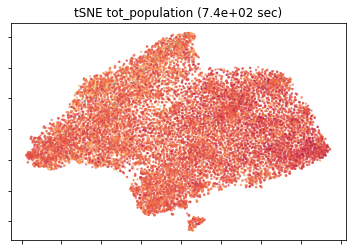

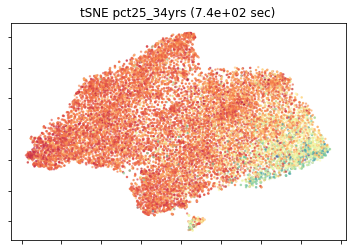

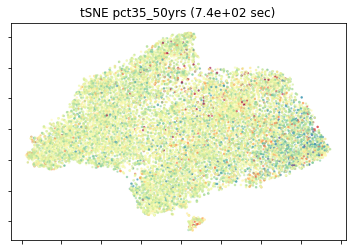

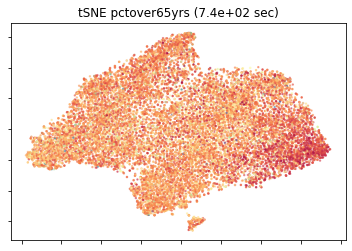

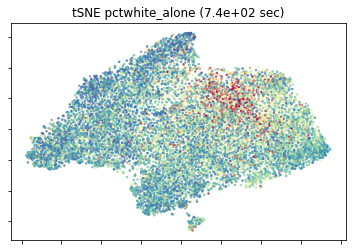

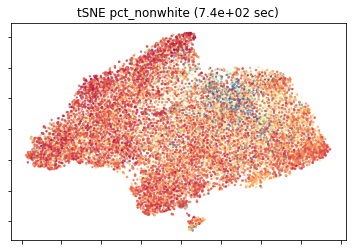

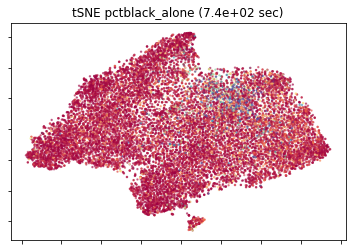

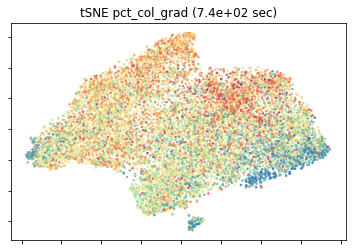

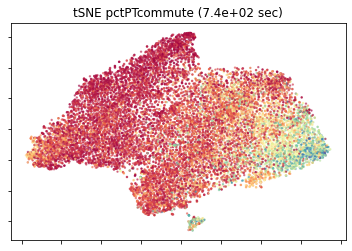

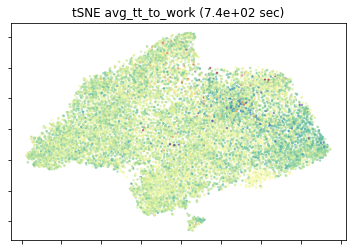

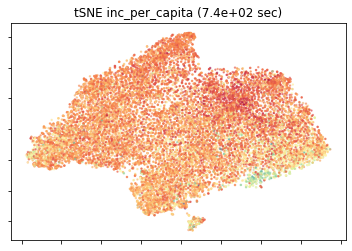

In [93]:
for c in ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute', 'avg_tt_to_work','inc_per_capita']:
    fig, ax = plt.subplots()
    ax.scatter(Y[:, 0], Y[:, 1], c=ct_df[c], s=2, cmap=plt.cm.Spectral, alpha=0.5)
    ax.set_title("%s (%.2g sec)" % ('tSNE '+c, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight');